In [2]:
import pandas as pd 
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import torch
import math
import itertools

import torch.nn.functional as F


In [3]:
'''
    Relevant data for our model:
    
    ss_id : id number of the PV system. these are the keys in the netcdf file
    latitude_rounded : latitude of the PV system (I think degrees)
    longitude_rounded : longitude of the PV system (I think degrees)
    orientation : cardinal orientation of PV panels ? TODO: confirm
    tilt : tilt angle of the PV panels
'''
pv_metadata = pd.read_csv("../data/metadata.csv")
pv_metadata.head()     # Prints first 5 rows of metadata


,ss_id,latitude_rounded,longitude_rounded,llsoacd,orientation,tilt,kwp,operational_at
0,2405,53.53,-1.63,E01007430,180.0,35.0,3.36,2010-11-18
1,2406,54.88,-1.38,E01008780,315.0,30.0,1.89,2010-12-03
2,2407,54.88,-1.38,E01008780,225.0,30.0,1.89,2010-12-03
3,2408,54.88,-1.38,E01008780,225.0,30.0,1.89,2010-12-03
4,2409,54.88,-1.38,E01008780,225.0,30.0,1.89,2010-12-03


In [4]:
fn = '../data/pv.netcdf'
#ncf = nc.Dataset(fn)   # Using xarray to open files instead of netcdf for pipeline simplicity
ncf = xr.open_dataset(fn, engine="h5netcdf")

In [5]:
print(ncf.keys())

KeysView(<xarray.Dataset>
Dimensions:   (datetime: 387254)
Coordinates:
  * datetime  (datetime) datetime64[ns] 2018-01-01T06:05:00 ... 2021-10-27T23...
Data variables: (12/1311)
    10003     (datetime) float32 ...
    10004     (datetime) float32 ...
    10005     (datetime) float32 ...
    10048     (datetime) float32 ...
    10049     (datetime) float32 ...
    10063     (datetime) float32 ...
    ...        ...
    9870      (datetime) float32 ...
    9871      (datetime) float32 ...
    9902      (datetime) float32 ...
    9903      (datetime) float32 ...
    9960      (datetime) float32 ...
    9989      (datetime) float32 ...)


In [6]:
list_of_pv_systems = list(ncf.keys())  # list of strings of PV system ss_id's

print(list_of_pv_systems)

['10003', '10004', '10005', '10048', '10049', '10063', '10064', '10082', '10086', '10131', '10149', '10150', '10167', '10168', '10169', '10190', '10205', '10206', '10207', '10222', '10254', '10278', '10280', '10361', '10366', '10367', '10425', '10426', '10437', '10438', '10440', '10466', '10497', '10509', '10511', '10512', '10513', '10523', '10528', '10531', '10532', '10533', '10547', '10548', '10585', '10586', '10589', '10595', '10619', '10620', '10630', '10631', '10639', '10640', '10648', '10649', '10650', '10685', '10686', '10689', '10692', '10693', '10702', '10704', '10791', '10792', '10793', '10794', '10835', '10837', '10838', '10840', '10841', '10842', '10843', '10844', '10890', '10929', '10973', '10974', '10975', '10976', '11040', '11042', '11151', '11153', '11166', '11174', '11175', '11176', '11287', '11401', '11438', '11441', '11465', '11466', '11494', '11522', '11558', '11573', '11590', '11591', '11628', '11630', '11655', '11656', '11657', '11685', '11687', '11688', '11712', 

In [7]:
on_pv_system = ncf[list_of_pv_systems[0]].to_dataframe()
on_pv_system = on_pv_system[on_pv_system.index < '2021-06-02']
on_pv_system = on_pv_system[on_pv_system.index > '2021-06-01 00:00:00']
print(on_pv_system.index)
on_pv = np.array(on_pv_system)
on_pv = list(itertools.chain(*on_pv))
print(len(on_pv))

DatetimeIndex(['2021-06-01 00:05:00', '2021-06-01 00:10:00',
               '2021-06-01 00:15:00', '2021-06-01 00:20:00',
               '2021-06-01 00:25:00', '2021-06-01 00:30:00',
               '2021-06-01 00:35:00', '2021-06-01 00:40:00',
               '2021-06-01 00:45:00', '2021-06-01 00:50:00',
               ...
               '2021-06-01 23:10:00', '2021-06-01 23:15:00',
               '2021-06-01 23:20:00', '2021-06-01 23:25:00',
               '2021-06-01 23:30:00', '2021-06-01 23:35:00',
               '2021-06-01 23:40:00', '2021-06-01 23:45:00',
               '2021-06-01 23:50:00', '2021-06-01 23:55:00'],
              dtype='datetime64[ns]', name='datetime', length=287, freq=None)
287


2021-06-01 00:10:00


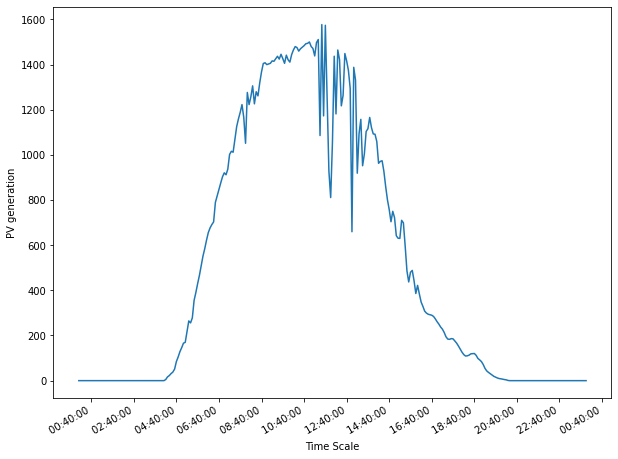

In [8]:
# Plot/visualize PV production for single system in one day
'''
'''
plt.figure(figsize=(10,8))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter(" %H:%M:%S"))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=120))
x_dates = [dt.datetime.strptime(str(pd.Timestamp(d)), '%Y-%m-%d %H:%M:%S') for d in on_pv_system.index]
print(x_dates[1])
temp_x = np.linspace(1, len(on_pv), num=len(on_pv))
plt.plot(x_dates, on_pv)
plt.xlabel('Time Scale')
plt.ylabel('PV generation')
plt.gcf().autofmt_xdate()
plt.show()


In [9]:
'''

model input: 
- date + time from which to forecast next 24h
- latitutde/longitude
- orientation/tilt
- kwp

model output:
- 24 hour generation forecast in increments of 15 min (CAN BE CHANGED)

Current TODO:

- run lat/lon/date through a trigonometric transformation to reduce endpoint singularities (https://arxiv.org/pdf/2011.06125.pdf)
- load in satellite image data, run it through normalization

'''

'\n\nmodel input: \n- date + time from which to forecast next 24h\n- latitutde/longitude\n- orientation/tilt\n- kwp\n\nmodel output:\n- 24 hour generation forecast in increments of 15 min (CAN BE CHANGED)\n\nCurrent TODO:\n\n- run lat/lon/date through a trigonometric transformation to reduce endpoint singularities (https://arxiv.org/pdf/2011.06125.pdf)\n- load in satellite image data, run it through normalization\n\n'

# Preprocessing
